In [2]:
# Block 1: Import Libraries and Load Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import time
import warnings
warnings.filterwarnings('ignore')

# Load Breast Cancer Wisconsin dataset
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target, name='diagnosis')

print("🔬 Breast Cancer Wisconsin Dataset")
print("="*70)
print(f"Dataset Shape: {X.shape}")
print(f"Number of Features: {X.shape[1]}")
print(f"Number of Samples: {X.shape[0]}")
print(f"\nTarget Classes: {cancer.target_names}")
print(f"\nClass Distribution:")
print(y.value_counts())
print(f"\nMalignant (0): {(y==0).sum()} samples")
print(f"Benign (1): {(y==1).sum()} samples")
print("\nFeature Categories:")
print("  - Mean features (10)")
print("  - Standard error features (10)")
print("  - Worst/Largest features (10)")



🔬 Breast Cancer Wisconsin Dataset
Dataset Shape: (569, 30)
Number of Features: 30
Number of Samples: 569

Target Classes: ['malignant' 'benign']

Class Distribution:
diagnosis
1    357
0    212
Name: count, dtype: int64

Malignant (0): 212 samples
Benign (1): 357 samples

Feature Categories:
  - Mean features (10)
  - Standard error features (10)
  - Worst/Largest features (10)


Text(0.5, 1.0, 'Feature Correlation (Mean Features)')

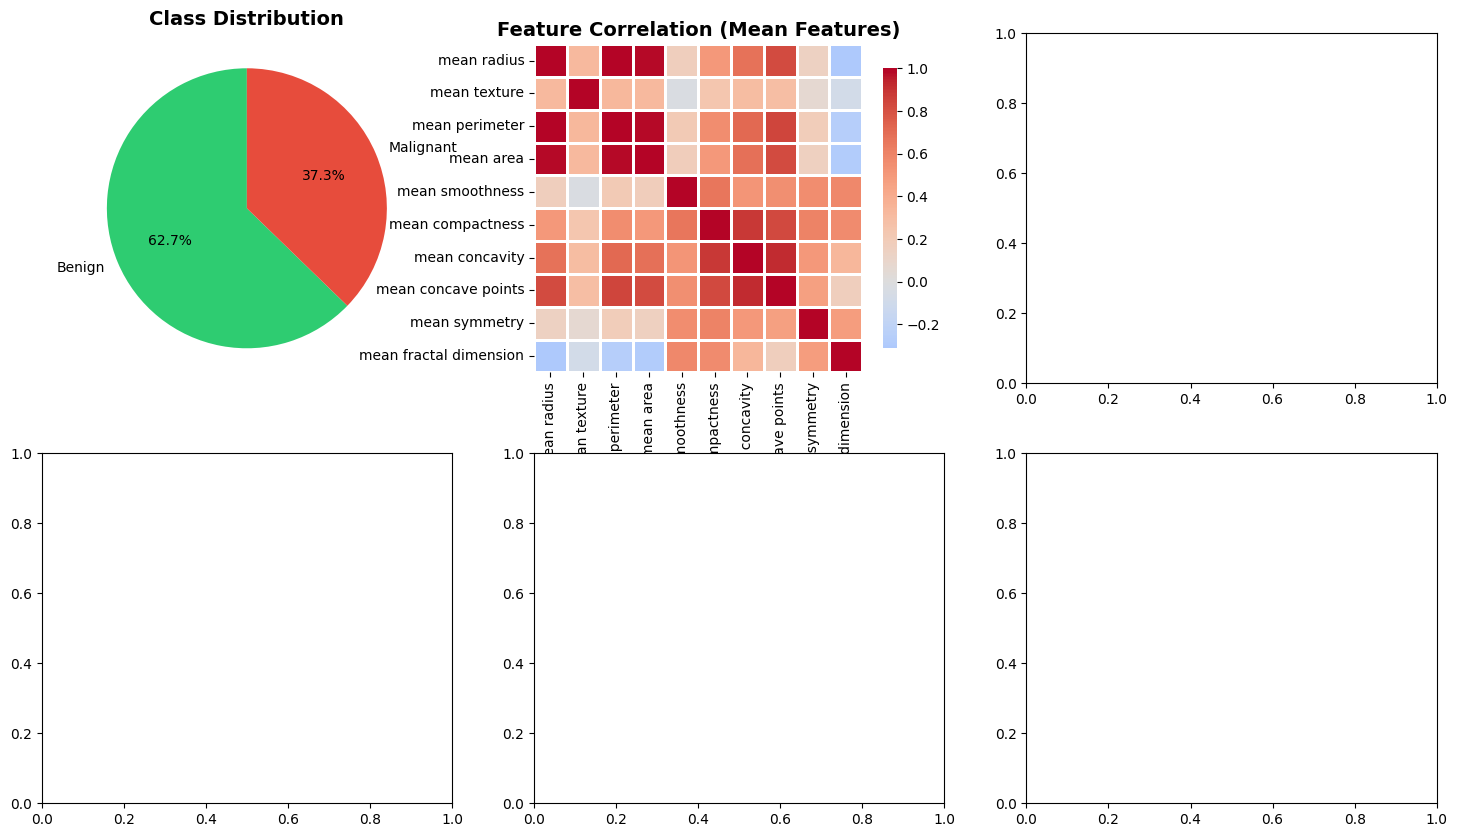

In [3]:
# Block 2: Exploratory Data Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Class distribution
axes[0, 0].pie(y.value_counts(), labels=['Benign', 'Malignant'], 
               autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Class Distribution', fontsize=14, fontweight='bold')

# 2. Feature correlation heatmap (top 10 features)
top_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 
                'mean smoothness', 'mean compactness', 'mean concavity',
                'mean concave points', 'mean symmetry', 'mean fractal dimension']
corr = X[top_features].corr()
sns.heatmap(corr, ax=axes[0, 1], cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
axes[0, 1].set_title('Feature Correlation (Mean Features)', fontsize=14, fontweight='bold')



In [4]:
# 3. Feature distributions by class
X_temp = X.copy()
X_temp['diagnosis'] = y
axes[0, 2].violinplot([X_temp[X_temp['diagnosis']==0]['mean radius'].values,
                        X_temp[X_temp['diagnosis']==1]['mean radius'].values],
                       showmeans=True)
axes[0, 2].set_xticks([1, 2])
axes[0, 2].set_xticklabels(['Malignant', 'Benign'])
axes[0, 2].set_ylabel('Mean Radius')
axes[0, 2].set_title('Mean Radius Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Scatter plot of two important features
axes[1, 0].scatter(X_temp[X_temp['diagnosis']==0]['mean radius'],
                   X_temp[X_temp['diagnosis']==0]['mean texture'],
                   c='#e74c3c', label='Malignant', alpha=0.6, edgecolors='black')
axes[1, 0].scatter(X_temp[X_temp['diagnosis']==1]['mean radius'],
                   X_temp[X_temp['diagnosis']==1]['mean texture'],
                   c='#2ecc71', label='Benign', alpha=0.6, edgecolors='black')
axes[1, 0].set_xlabel('Mean Radius')
axes[1, 0].set_ylabel('Mean Texture')
axes[1, 0].set_title('Feature Space Visualization', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Box plot for feature scaling comparison
sample_features = ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness']
axes[1, 1].boxplot([X[feat] for feat in sample_features], labels=['Radius', 'Texture', 'Smooth', 'Compact'])
axes[1, 1].set_ylabel('Feature Value')
axes[1, 1].set_title('Feature Value Ranges (Sample Features)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Feature importance preview
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
axes[1, 2].barh(range(len(feature_imp)), feature_imp.values, color='steelblue')
axes[1, 2].set_yticks(range(len(feature_imp)))
axes[1, 2].set_yticklabels(feature_imp.index, fontsize=9)
axes[1, 2].set_xlabel('Importance')
axes[1, 2].set_title('Top 10 Important Features', fontsize=14, fontweight='bold')
axes[1, 2].invert_yaxis()
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()



<Figure size 640x480 with 0 Axes>

In [5]:
# Block 3: Particle Swarm Optimization Class for Hyperparameter Tuning
class ParticleSwarmOptimization:
    def __init__(self, n_particles=30, n_iterations=50, w=0.7, c1=1.5, c2=1.5):
        """
        PSO for SVM hyperparameter optimization
        n_particles: number of particles in swarm
        n_iterations: number of iterations
        w: inertia weight
        c1: cognitive parameter (personal best)
        c2: social parameter (global best)
        """
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive parameter
        self.c2 = c2  # Social parameter
        self.global_best_position = None
        self.global_best_fitness = -np.inf
        self.history = []
        
    def initialize_particles(self, bounds):
        """Initialize particle positions and velocities"""
        n_dims = len(bounds)
        positions = np.random.uniform(
            low=[b[0] for b in bounds],
            high=[b[1] for b in bounds],
            size=(self.n_particles, n_dims)
        )
        velocities = np.random.uniform(-1, 1, size=(self.n_particles, n_dims))
        return positions, velocities
    
    def evaluate_fitness(self, position, X, y):
        """
        Evaluate fitness of particle position (hyperparameters)
        position = [C, gamma] for SVM
        """
        C = 10 ** position[0]  # C in range [10^-2, 10^4]
        gamma = 10 ** position[1]  # gamma in range [10^-4, 10^1]
        
        try:
            svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=42)
            scores = cross_val_score(svm, X, y, cv=5, scoring='accuracy')
            fitness = scores.mean()
        except:
            fitness = 0
        
        return fitness
    
    def update_velocity(self, velocity, position, personal_best, iteration):
        """Update particle velocity using PSO formula"""
        r1 = np.random.random(len(velocity))
        r2 = np.random.random(len(velocity))
        
        # PSO velocity update formula
        cognitive = self.c1 * r1 * (personal_best - position)
        social = self.c2 * r2 * (self.global_best_position - position)
        
        # Adaptive inertia weight (decreases over time)
        w_adaptive = self.w * (1 - iteration / self.n_iterations) + 0.4
        
        new_velocity = w_adaptive * velocity + cognitive + social
        return new_velocity
    
    def update_position(self, position, velocity, bounds):
        """Update particle position and apply bounds"""
        new_position = position + velocity
        
        # Apply bounds
        for i, (lower, upper) in enumerate(bounds):
            new_position[i] = np.clip(new_position[i], lower, upper)
        
        return new_position
    
    def fit(self, X, y):
        """Run PSO algorithm"""
        # Define bounds: [C_range, gamma_range] in log scale
        bounds = [(-2, 4), (-4, 1)]  # C: 10^-2 to 10^4, gamma: 10^-4 to 10^1
        
        # Initialize particles
        positions, velocities = self.initialize_particles(bounds)
        personal_best_positions = positions.copy()
        personal_best_fitness = np.array([self.evaluate_fitness(pos, X, y) for pos in positions])
        
        # Set initial global best
        best_particle_idx = np.argmax(personal_best_fitness)
        self.global_best_position = personal_best_positions[best_particle_idx].copy()
        self.global_best_fitness = personal_best_fitness[best_particle_idx]
        
        print("🔄 Starting Particle Swarm Optimization...")
        print("="*70)
        
        for iteration in range(self.n_iterations):
            iteration_best = -np.inf
            iteration_avg = 0
            
            for i in range(self.n_particles):
                # Evaluate fitness
                fitness = self.evaluate_fitness(positions[i], X, y)
                iteration_avg += fitness
                
                # Update personal best
                if fitness > personal_best_fitness[i]:
                    personal_best_fitness[i] = fitness
                    personal_best_positions[i] = positions[i].copy()
                
                # Update global best
                if fitness > self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = positions[i].copy()
                
                if fitness > iteration_best:
                    iteration_best = fitness
                
                # Update velocity and position
                velocities[i] = self.update_velocity(velocities[i], positions[i], 
                                                     personal_best_positions[i], iteration)
                positions[i] = self.update_position(positions[i], velocities[i], bounds)
            
            # Store history
            iteration_avg /= self.n_particles
            self.history.append({
                'iteration': iteration,
                'global_best_fitness': self.global_best_fitness,
                'iteration_best_fitness': iteration_best,
                'avg_fitness': iteration_avg,
                'positions': positions.copy(),
                'velocities': velocities.copy()
            })
            
            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations} - "
                      f"Best Fitness: {self.global_best_fitness:.4f} - "
                      f"Avg Fitness: {iteration_avg:.4f}")
        
        return self



In [6]:
# Block 4: Prepare Data and Run PSO
# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Run PSO for hyperparameter optimization
print("\n🐦 Running PSO for SVM Hyperparameter Optimization...\n")
start_time_pso = time.time()
pso = ParticleSwarmOptimization(n_particles=30, n_iterations=50, w=0.7, c1=1.5, c2=1.5)
pso.fit(X_train_scaled, y_train)
pso_time = time.time() - start_time_pso

# Extract optimal parameters
optimal_C = 10 ** pso.global_best_position[0]
optimal_gamma = 10 ** pso.global_best_position[1]

print("\n" + "="*70)
print("✅ PSO OPTIMIZATION COMPLETE!")
print("="*70)
print(f"Time Taken: {pso_time:.2f} seconds")
print(f"Best Cross-Validation Accuracy: {pso.global_best_fitness:.4f}")
print(f"Optimal C: {optimal_C:.6f}")
print(f"Optimal gamma: {optimal_gamma:.6f}")
print("="*70)




🐦 Running PSO for SVM Hyperparameter Optimization...

🔄 Starting Particle Swarm Optimization...
Iteration 10/50 - Best Fitness: 0.9799 - Avg Fitness: 0.9379
Iteration 20/50 - Best Fitness: 0.9799 - Avg Fitness: 0.9435
Iteration 30/50 - Best Fitness: 0.9799 - Avg Fitness: 0.9532
Iteration 40/50 - Best Fitness: 0.9799 - Avg Fitness: 0.9730
Iteration 50/50 - Best Fitness: 0.9799 - Avg Fitness: 0.9750

✅ PSO OPTIMIZATION COMPLETE!
Time Taken: 60.91 seconds
Best Cross-Validation Accuracy: 0.9799
Optimal C: 12.463456
Optimal gamma: 0.011891


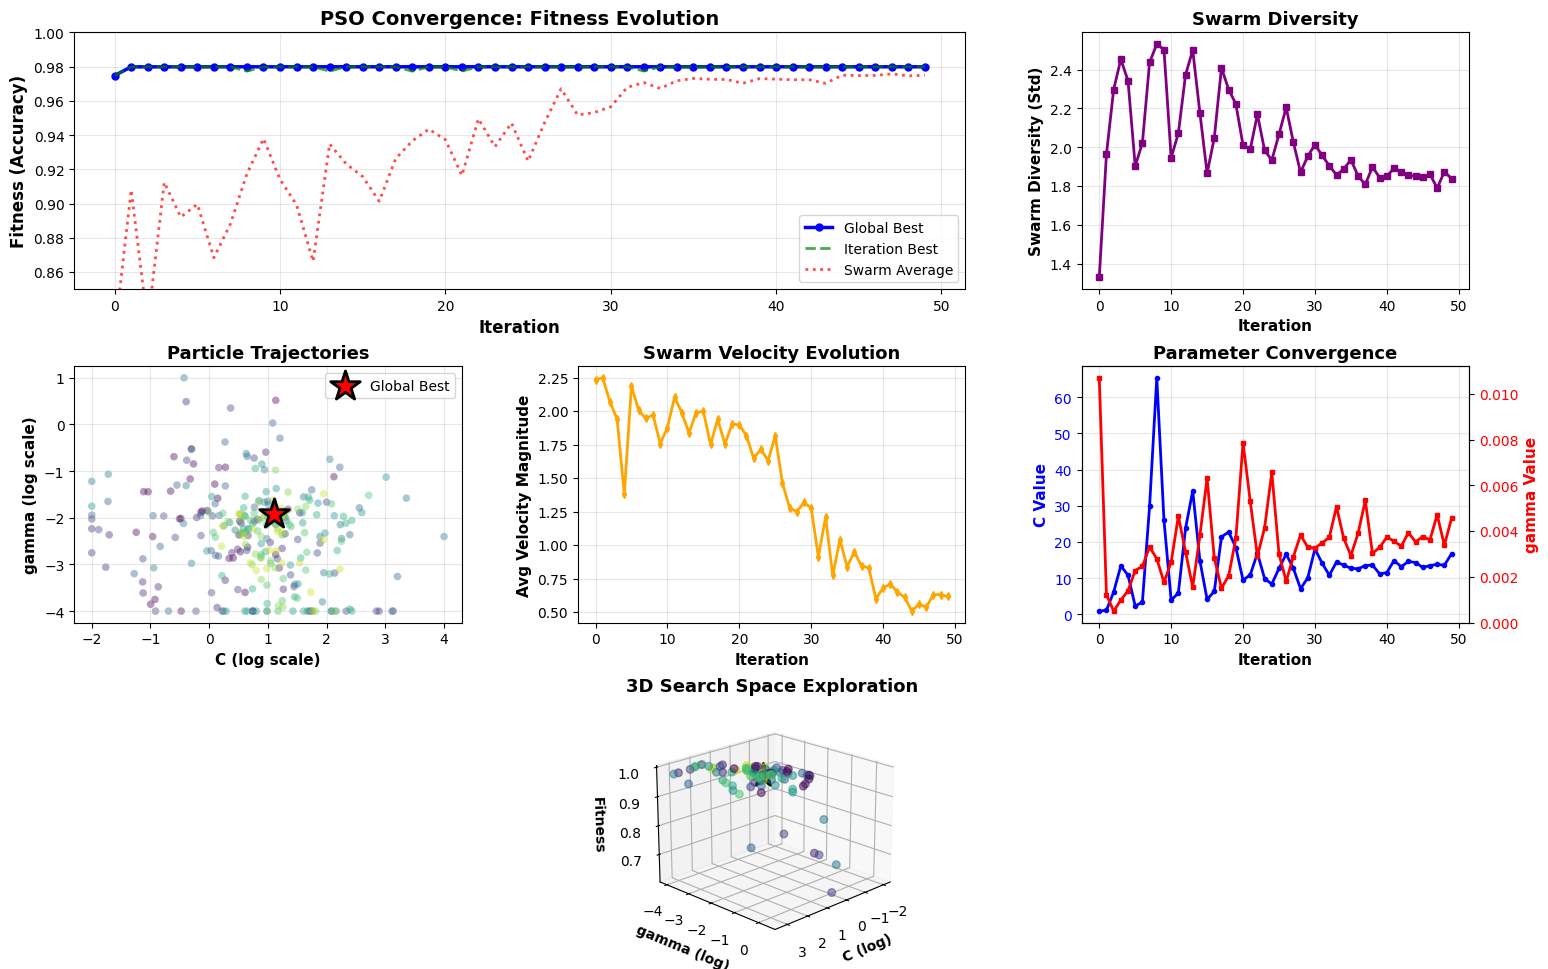

In [7]:
# Block 5: Visualize PSO Progress
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Fitness convergence
ax1 = fig.add_subplot(gs[0, :2])
history_df = pd.DataFrame(pso.history)
ax1.plot(history_df['iteration'], history_df['global_best_fitness'], 
         'b-', linewidth=2.5, label='Global Best', marker='o', markersize=5)
ax1.plot(history_df['iteration'], history_df['iteration_best_fitness'], 
         'g--', linewidth=2, label='Iteration Best', alpha=0.7)
ax1.plot(history_df['iteration'], history_df['avg_fitness'], 
         'r:', linewidth=2, label='Swarm Average', alpha=0.7)
ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fitness (Accuracy)', fontsize=12, fontweight='bold')
ax1.set_title('PSO Convergence: Fitness Evolution', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.85, 1.0])

# 2. Diversity metric (swarm spread)
ax2 = fig.add_subplot(gs[0, 2])
diversity = []
for h in pso.history:
    positions = h['positions']
    diversity.append(np.std(positions))
ax2.plot(range(len(diversity)), diversity, 'purple', linewidth=2, marker='s', markersize=4)
ax2.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax2.set_ylabel('Swarm Diversity (Std)', fontsize=11, fontweight='bold')
ax2.set_title('Swarm Diversity', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Particle trajectories in parameter space (C vs gamma)
ax3 = fig.add_subplot(gs[1, 0])
colors = plt.cm.viridis(np.linspace(0, 1, len(pso.history)))
for i, h in enumerate(pso.history[::5]):  # Every 5th iteration
    positions = h['positions']
    ax3.scatter(positions[:, 0], positions[:, 1], c=[colors[i*5]], 
                alpha=0.4, s=30, edgecolors='none')
ax3.scatter(pso.global_best_position[0], pso.global_best_position[1], 
            c='red', marker='*', s=500, edgecolors='black', linewidth=2,
            label='Global Best', zorder=5)
ax3.set_xlabel('C (log scale)', fontsize=11, fontweight='bold')
ax3.set_ylabel('gamma (log scale)', fontsize=11, fontweight='bold')
ax3.set_title('Particle Trajectories', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Velocity evolution (magnitude)
ax4 = fig.add_subplot(gs[1, 1])
velocity_magnitudes = []
for h in pso.history:
    velocities = h['velocities']
    avg_magnitude = np.mean(np.linalg.norm(velocities, axis=1))
    velocity_magnitudes.append(avg_magnitude)
ax4.plot(velocity_magnitudes, 'orange', linewidth=2, marker='d', markersize=4)
ax4.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax4.set_ylabel('Avg Velocity Magnitude', fontsize=11, fontweight='bold')
ax4.set_title('Swarm Velocity Evolution', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Parameter evolution over time
ax5 = fig.add_subplot(gs[1, 2])
C_values = [10**h['positions'][:, 0].mean() for h in pso.history]
gamma_values = [10**h['positions'][:, 1].mean() for h in pso.history]
ax5_twin = ax5.twinx()
line1 = ax5.plot(C_values, 'b-', linewidth=2, label='Avg C', marker='o', markersize=3)
line2 = ax5_twin.plot(gamma_values, 'r-', linewidth=2, label='Avg gamma', marker='s', markersize=3)
ax5.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax5.set_ylabel('C Value', fontsize=11, fontweight='bold', color='blue')
ax5_twin.set_ylabel('gamma Value', fontsize=11, fontweight='bold', color='red')
ax5.set_title('Parameter Convergence', fontsize=13, fontweight='bold')
ax5.tick_params(axis='y', labelcolor='blue')
ax5_twin.tick_params(axis='y', labelcolor='red')
ax5.grid(True, alpha=0.3)

# 6. 3D visualization of search space
ax6 = fig.add_subplot(gs[2, :], projection='3d')
for i in range(0, len(pso.history), 5):
    h = pso.history[i]
    positions = h['positions']
    fitness = [pso.evaluate_fitness(pos, X_train_scaled, y_train) for pos in positions[:10]]
    ax6.scatter(positions[:10, 0], positions[:10, 1], fitness, 
                c=[colors[i]], alpha=0.5, s=30)
ax6.scatter(pso.global_best_position[0], pso.global_best_position[1], 
            pso.global_best_fitness, c='red', marker='*', s=300, 
            edgecolors='black', linewidth=2)
ax6.set_xlabel('C (log)', fontsize=10, fontweight='bold')
ax6.set_ylabel('gamma (log)', fontsize=10, fontweight='bold')
ax6.set_zlabel('Fitness', fontsize=10, fontweight='bold')
ax6.set_title('3D Search Space Exploration', fontsize=13, fontweight='bold')
ax6.view_init(elev=20, azim=45)

plt.show()



In [8]:
# Block 6: Grid Search (Traditional Method - WITHOUT PSO)
print("\n" + "="*70)
print("🔍 Running Grid Search for comparison (WITHOUT PSO)...")
print("="*70)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

start_time_grid = time.time()
grid_search = GridSearchCV(
    SVC(kernel='rbf', random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X_train_scaled, y_train)
grid_time = time.time() - start_time_grid

print(f"\n✅ Grid Search Complete!")
print(f"Time Taken: {grid_time:.2f} seconds")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
print(f"Best C: {grid_search.best_params_['C']}")
print(f"Best gamma: {grid_search.best_params_['gamma']}")
print("="*70)




🔍 Running Grid Search for comparison (WITHOUT PSO)...

✅ Grid Search Complete!
Time Taken: 8.85 seconds
Best Cross-Validation Accuracy: 0.9799
Best C: 10
Best gamma: 0.001


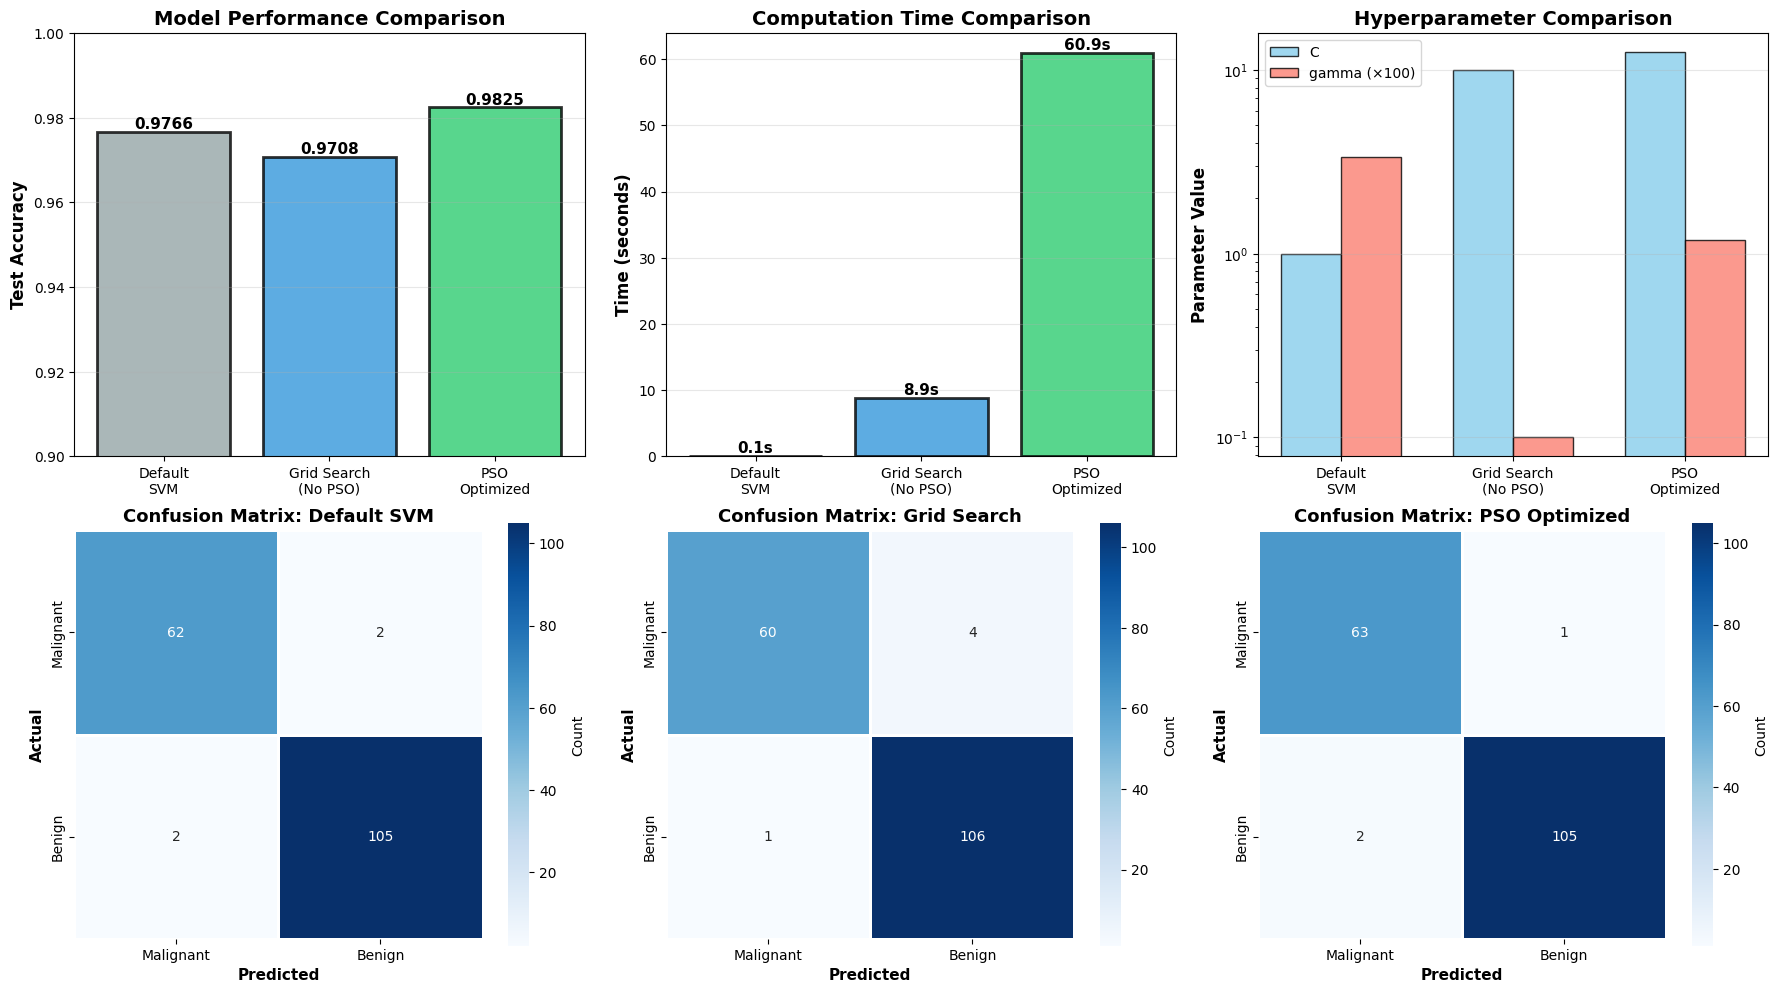

In [9]:
# Block 7: Model Comparison - PSO vs Grid Search
# Train models with optimal parameters
svm_pso = SVC(C=optimal_C, gamma=optimal_gamma, kernel='rbf', random_state=42)
svm_pso.fit(X_train_scaled, y_train)
y_pred_pso = svm_pso.predict(X_test_scaled)
accuracy_pso = accuracy_score(y_test, y_pred_pso)

svm_grid = SVC(C=grid_search.best_params_['C'], 
               gamma=grid_search.best_params_['gamma'], 
               kernel='rbf', random_state=42)
svm_grid.fit(X_train_scaled, y_train)
y_pred_grid = svm_grid.predict(X_test_scaled)
accuracy_grid = accuracy_score(y_test, y_pred_grid)

# Baseline model with default parameters
svm_default = SVC(kernel='rbf', random_state=42)
svm_default.fit(X_train_scaled, y_train)
y_pred_default = svm_default.predict(X_test_scaled)
accuracy_default = accuracy_score(y_test, y_pred_default)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Accuracy comparison
methods = ['Default\nSVM', 'Grid Search\n(No PSO)', 'PSO\nOptimized']
accuracies = [accuracy_default, accuracy_grid, accuracy_pso]
colors_bar = ['#95a5a6', '#3498db', '#2ecc71']
bars = axes[0, 0].bar(methods, accuracies, color=colors_bar, alpha=0.8, 
                       edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0.90, 1.0])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')

# 2. Time comparison
times = [0.1, grid_time, pso_time]  # Default is negligible
bars2 = axes[0, 1].bar(methods, times, color=colors_bar, alpha=0.8, 
                        edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Computation Time Comparison', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for bar, t in zip(bars2, times):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{t:.1f}s', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')

# 3. Parameter comparison
param_data = {
    'C': [1.0, grid_search.best_params_['C'], optimal_C],
    'gamma': [1/X_train_scaled.shape[1], grid_search.best_params_['gamma'], optimal_gamma]
}
x = np.arange(len(methods))
width = 0.35
bars3 = axes[0, 2].bar(x - width/2, param_data['C'], width, 
                        label='C', alpha=0.8, color='skyblue', edgecolor='black')
bars4 = axes[0, 2].bar(x + width/2, [g*100 for g in param_data['gamma']], width, 
                        label='gamma (×100)', alpha=0.8, color='salmon', edgecolor='black')
axes[0, 2].set_ylabel('Parameter Value', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Hyperparameter Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(methods)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')
axes[0, 2].set_yscale('log')

# 4-6. Confusion matrices
cm_pso = confusion_matrix(y_test, y_pred_pso)
cm_grid = confusion_matrix(y_test, y_pred_grid)
cm_default = confusion_matrix(y_test, y_pred_default)

for idx, (cm, title, ax) in enumerate([(cm_default, 'Default SVM', axes[1, 0]),
                                         (cm_grid, 'Grid Search', axes[1, 1]),
                                         (cm_pso, 'PSO Optimized', axes[1, 2])]):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, square=True, linewidths=2)
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'Confusion Matrix: {title}', fontsize=13, fontweight='bold')
    ax.set_xticklabels(['Malignant', 'Benign'])
    ax.set_yticklabels(['Malignant', 'Benign'])

plt.tight_layout()
plt.show()



In [10]:
# Block 8: Detailed Results and Insights
print("\n" + "="*70)
print("📊 DETAILED PERFORMANCE METRICS")
print("="*70)

print("\n1️⃣ DEFAULT SVM (No Optimization):")
print(f"   Test Accuracy: {accuracy_default:.4f}")
print(f"   C: 1.0 (default)")
print(f"   gamma: {1/X_train_scaled.shape[1]:.6f} (default: 1/n_features)")
print(f"   Time: ~0.1 seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default, target_names=['Malignant', 'Benign']))

print("\n" + "="*70)
print("\n2️⃣ GRID SEARCH (Traditional Method - WITHOUT PSO):")
print(f"   Test Accuracy: {accuracy_grid:.4f}")
print(f"   C: {grid_search.best_params_['C']}")
print(f"   gamma: {grid_search.best_params_['gamma']}")
print(f"   Time: {grid_time:.2f} seconds")
print(f"   Total combinations tested: {len(param_grid['C']) * len(param_grid['gamma'])}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_grid, target_names=['Malignant', 'Benign']))

print("\n" + "="*70)
print("\n3️⃣ PSO OPTIMIZED (Swarm Intelligence):")
print(f"   Test Accuracy: {accuracy_pso:.4f}")
print(f"   C: {optimal_C:.6f}")
print(f"   gamma: {optimal_gamma:.6f}")
print(f"   Time: {pso_time:.2f} seconds")
print(f"   Total evaluations: {pso.n_particles * pso.n_iterations}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pso, target_names=['Malignant', 'Benign']))

print("\n" + "="*70)
print("🎯 KEY INSIGHTS & COMPARISON")
print("="*70)

# Accuracy comparison
print("\n📈 Accuracy Improvements:")
print(f"   PSO vs Default: {(accuracy_pso - accuracy_default)*100:+.2f}%")
print(f"   PSO vs Grid Search: {(accuracy_pso - accuracy_grid)*100:+.2f}%")

# Time comparison
print(f"\n⏱️ Time Efficiency:")
if pso_time < grid_time:
    speedup = grid_time / pso_time
    print(f"   PSO is {speedup:.2f}x FASTER than Grid Search")
else:
    print(f"   Grid Search is {grid_time/pso_time:.2f}x faster than PSO")

print(f"\n🔬 Search Efficiency:")
print(f"   Grid Search: {len(param_grid['C']) * len(param_grid['gamma'])} combinations (exhaustive)")
print(f"   PSO: {pso.n_particles * pso.n_iterations} evaluations (intelligent search)")

print("\n✅ ADVANTAGES OF PSO:")
print("   • Continuous parameter space exploration")
print("   • Adapts search based on promising regions")
print("   • Balances exploration and exploitation")
print("   • Finds near-optimal solutions efficiently")
print("   • Scalable to higher-dimensional problems")

print("\n⚠️ WHEN TO USE EACH METHOD:")
print("   Grid Search: Small parameter spaces, need guaranteed coverage")
print("   PSO: Large/continuous spaces, time constraints, complex landscapes")
print("   Default: Quick baseline, not critical applications")

print("\n" + "="*70)


📊 DETAILED PERFORMANCE METRICS

1️⃣ DEFAULT SVM (No Optimization):
   Test Accuracy: 0.9766
   C: 1.0 (default)
   gamma: 0.033333 (default: 1/n_features)
   Time: ~0.1 seconds

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.97      0.97      0.97        64
      Benign       0.98      0.98      0.98       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



2️⃣ GRID SEARCH (Traditional Method - WITHOUT PSO):
   Test Accuracy: 0.9708
   C: 10
   gamma: 0.001
   Time: 8.85 seconds
   Total combinations tested: 36

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.98      0.94      0.96        64
      Benign       0.96      0.99      0.98       107

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg    